### Домашнее задание к лекции «Feature Selection»

Вы получили основные навыки обработки данных, теперь пора испытать их на практике. Сейчас вам предстоит заняться задачей классификации.

Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

Здесь вы вольны делать что угодно. Я хочу видеть от вас:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.
7. Не забывайте, что у вас есть PCA (Метод главных компонент). Он может пригодиться.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, recall_score, confusion_matrix
from sklearn.decomposition import PCA

In [14]:
data = pd.read_csv("aac_shelter_outcomes.csv")
data.head()
# посмотрим на данные..

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78248 non-null  object
 1   animal_id         78256 non-null  object
 2   animal_type       78256 non-null  object
 3   breed             78256 non-null  object
 4   color             78256 non-null  object
 5   date_of_birth     78256 non-null  object
 6   datetime          78256 non-null  object
 7   monthyear         78256 non-null  object
 8   name              54370 non-null  object
 9   outcome_subtype   35963 non-null  object
 10  outcome_type      78244 non-null  object
 11  sex_upon_outcome  78254 non-null  object
dtypes: object(12)
memory usage: 7.2+ MB


In [4]:
# Есть пропуски.. надо будет отработать. Все данные являются категориальными

In [5]:
# Посмотрим что есть в отчете полезного
ProfileReport(data)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# Из отчета видим зависимость в данных: outcome_subtype и outcome_type, так как outcome_type целевая переменная, то outcome_subtype удалим
data.drop(['outcome_subtype'], axis=1, inplace=True)

In [7]:
# Проверим уникальность и посмотрим, что можно закодировать 
data.nunique()

age_upon_outcome       46
animal_id           70855
animal_type             5
breed                2128
color                 525
date_of_birth        5869
datetime            64361
monthyear           64361
name                14574
outcome_type            9
sex_upon_outcome        5
dtype: int64

In [16]:
# отбросим animal_id - он нам не нужен
data.drop(['animal_id'], axis=1, inplace=True)

In [17]:
# отбросим данные, которые не соответствуют постановки задачи
data = data[ data['outcome_type'].isin(['Adoption', 'Transfer']) ]

In [10]:
# подозрительно одинаковые данные в колонках datetime и monthyear. Кодичество уникальных тоже совпадает. Можно отбросить?
# Отберем данные, где не совпадает. посмотрим их количество
len(data[data.datetime != data.monthyear])

0

In [18]:
# видим выше,что разных данных нет,поэтому дропнем 1 признак
data.drop(['monthyear'], axis=1, inplace=True)

In [19]:
# надо что-то придумать с age_upon_outcome, судя по отчету профайлера есть и год и месяц и неделя и день. Попробуем преобразовать
# создадим функцию перевода в количество дней
def days(row):
   
    try:
        num, age = row.split()
    except:
        return 0
    
    if 'yaer' in row:
        res = 365 * int(num) 
    elif 'week' in row:
        res = 14 * int(num)
    elif 'day' in row:
        res = 1 * int(num)
    elif 'month' in row:
        res = 30 * int(num)
    else:
        res = 0
    
    return res

In [20]:
# Создадим новый параметр days и перезапишем его
data['age_upon_outcome'] = data.age_upon_outcome.apply(days)

In [21]:
# не верю, что имя (name) может влиять хоть на что-то, но оставлю. Все ж статистика все дела

In [22]:
# посмотрим что получилось
data

,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_type,sex_upon_outcome
0,28,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,NaN,Transfer,Intact Male
1,0,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Lucy,Transfer,Spayed Female
2,0,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,*Johnny,Adoption,Neutered Male
3,0,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,Monday,Transfer,Neutered Male
5,120,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,*Edgar,Transfer,Intact Male
...,...,...,...,...,...,...,...,...,...
78250,30,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:40:00,NaN,Adoption,Neutered Male
78251,30,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:26:00,NaN,Adoption,Spayed Female
78252,0,Dog,Mastiff Mix,Blue/White,2014-12-30T00:00:00,2018-02-01T18:06:00,Max,Adoption,Neutered Male
78254,60,Dog,Standard Schnauzer,Red,2017-11-13T00:00:00,2018-02-01T18:32:00,NaN,Adoption,Spayed Female


In [23]:
# не нравятся мне date_of_birth и datetime в таком бесполезном виде
# вычленю год
def years(row):   
    try:
        return int(row.split('-')[0])
    except:
        return 0

In [24]:
data.date_of_birth = data.date_of_birth.apply(years)
data.datetime = data.datetime.apply(years)

In [25]:
# перекодируем
LE = LabelEncoder()

lst_cat = ['animal_type', 'breed', 'color', 'name', 'outcome_type', 'sex_upon_outcome']

for i in lst_cat:
    data[i].fillna('None', inplace=True)
    
    
for i in lst_cat:        
    data[i] = LE.fit_transform(data[i])

In [26]:
# Посмотрим на конечные данные:
data

,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,name,outcome_type,sex_upon_outcome
0,28,1,803,291,2014,2014,9845,1,1
1,0,2,216,429,2012,2013,9097,1,3
2,0,2,1377,107,2013,2014,2580,0,2
3,0,2,1257,418,2005,2014,9565,1,2
5,120,2,1158,162,2013,2013,1564,1,1
...,...,...,...,...,...,...,...,...,...
78250,30,2,955,162,2017,2018,9845,0,2
78251,30,2,955,162,2017,2018,9845,0,3
78252,0,2,1213,107,2014,2018,9319,0,2
78254,60,2,1688,307,2017,2018,9845,0,3


In [ ]:
# видим 9 признаков

In [27]:
X = data.drop(['outcome_type'], axis=1)
y = data['outcome_type']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

In [29]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [30]:
# посмотрим на метрики качества
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      6663
           1       0.85      0.70      0.77      4660

    accuracy                           0.83     11323
   macro avg       0.83      0.81      0.82     11323
weighted avg       0.83      0.83      0.82     11323



In [36]:
model.score(x_test, y_test)

0.8192175218581648

In [37]:
# PCA

res = []
for d in [x for x in range(1,9)]:
    X2 = PCA(n_components=d).fit_transform(X)
    x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2)
    modelPCA = model.fit(x_train, y_train)
    print(f'var = {d}, score = {modelPCA.score(x_test, y_test)}')
    res.append(modelPCA.score(x_test, y_test))

var = 1, score = 0.6544202066590127
var = 2, score = 0.7148282257352292
var = 3, score = 0.7225117018458006
var = 4, score = 0.7323147575730813
var = 5, score = 0.7548352910006182
var = 6, score = 0.8025258323765786
var = 7, score = 0.8234566810915835
var = 8, score = 0.8216020489269629


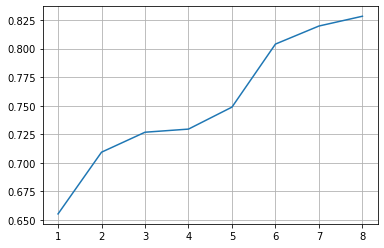

In [33]:
import matplotlib.pyplot as plt
plt.plot([x for x in range(1,9)], res)
plt.grid()

In [ ]:
# каквидим применение PCA существенно не улучшило нашу модель,все признаки являются значимыми. Можно отбросить только 1
# посмотрим без 1 признака

In [38]:
X3 = PCA(n_components=7).fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X3, y, test_size = 0.2)
modelPCA = model.fit(x_train, y_train)
modelPCA.score(x_test, y_test)

0.8253996290735671

In [ ]:
# нуууу слегка улучшили, но совсем слегка